# Lleva a cabo el Reconocimiento de Letras usando primero el nuevo Modelo ssd_mobilenet_v2 entrenado con TensorFlow (*detector*), y luego el Modelo ConvNet CNN-Letras entrenado anteriomente (*classifier*)


0) Preparar ambiente e instalar paquetes:

In [1]:
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
# Baja e instala los parquetes de 'Object Detection' de Tensor Flow a utilizar 
# en el disco temporal de Colab (demora un ratito)
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
model_dir = 'training/'

!python object_detection/builders/model_builder_test.py

os.environ['PYTHONPATH'] += ':/content/models/research/object_detection:/content/models/research/slim/object_detection'

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa


1) Cargar librerías:

In [3]:
from IPython.display import Image, display
from PIL import Image as ImPIL
import numpy as np
import os
import os.path

import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO

import json
from keras.models import model_from_json
from keras.models import load_model

print ("Librerías cargadas.")

Librerías cargadas.


Using TensorFlow backend.


2) Montar el Drive:

In [4]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoObjDet-Carteles'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


3) Preparar los modelos para hacer el reconocimiento:

In [5]:
## carga el modelo ssd_mobilenet_v2 para detectar letras y números

# path donde está el modelo exportado
ModelObjDetEntrenado = path + '/Carteles/modelTF/frozen_inference_graph.pb'

# archivo con lista de etiquetas para mostrar 
labelMapFile = path + '/Carteles/label_map.pbtxt'

# se debe ubicar en el directorio correspondiente
%cd /content/models/research/object_detection


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(ModelObjDetEntrenado, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(labelMapFile)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

# función auxiliar para ejecutar el modelo
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


print("Modelo objDetector-Carteles cargado: [", ModelObjDetEntrenado, "], [", labelMapFile, "] ")


/content/models/research/object_detection
Modelo objDetector-Carteles cargado: [ /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/modelTF/frozen_inference_graph.pb ], [ /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/label_map.pbtxt ] 


In [6]:
## carga modelo ConvNet para reconocer Letras

# define los nombres de los archivos a utilizar para leer/grabar el modelo
pathCNN = '/content/gdrive/My Drive/IA/demoConvNet-Letras'
history_file_name = pathCNN + '/Model/CNN_L_history_dump_final.json'
weights_file_name = pathCNN + '/Model/CNN_L_model_final.h5'
model_json_file_name = pathCNN + '/Model/CNN_L_model_final.json'
model_req_image_size = (128, 128)

# carga modelo ya grabado de ConvNet
if os.path.isfile(model_json_file_name):
    classifier = load_model(weights_file_name)

    if os.path.isfile(history_file_name):
      h = json.load(open(history_file_name, 'r'))
      print("Modelo CNN-Letras cargado: [", weights_file_name, "], [", history_file_name, "] y [", model_json_file_name, "] ")
    else: 
      print("No se encuentra modelo CNN-Letras para cargar")
else:   
    print("No se encuentra modelo CNN-Letras para cargar")


# carga la lista de clases si no está definida   
import csv
with open( pathCNN + '/Model/clasesLetrasNros.csv', mode='r') as csvfile:
    all_classes = list(csv.reader(csvfile))[0]
print('Definición de las clases: ', all_classes)
##['4', '5', '2', '7', '9', '6', '8', '3', '1', 'B', 'A', '0', 'E', 'F', 'D', 'C', 'G', 'K', 'I', 'J', 'H', 'M', 'N', 'L', 'O', 'Q', 'P', 'R', 'V', 'U', 'Z', 'W', 'X', 'S', 'Y', 'T']


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Modelo CNN-Letras cargado: [ /content/gdrive/My Drive/IA/demoConvNet-Letras/Model/CNN_L_model_final.h5 ], [ /content/gdrive/My Drive/IA/demoConvNet-Letras/Model/CNN_L_history_dump_final.json ] y [ /content/gdrive/My Drive/IA/demoConvNet-Letras/Model/CNN_L_model_final.json ] 
Definición de las clases:  ['4', '5', '2', '7', '9', '6', '8', '3', '1', 'B', 'A', '0', 'E', 'F', 'D', 'C', 'G', 'K', 'I', 'J', 'H', 'M', 'N', 'L', 'O', 'Q', 'P', 'R', 'V', 'U', 'Z', 'W', 'X', 'S', 'Y', 'T']


4) Llevar a cabo el reconocimiento sobre imágenes de prueba:

In [15]:
# define la carpeta donde están las imágenes para procesar
#dirTest = path + '/Carteles/validation/images' 

dirTest = '/content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images'

# levanta las imágenes de prueba para procesar
process_FileNames = [ fn for fn in os.listdir( dirTest ) if fn.endswith('.png') or fn.endswith('.jpg') ]
print("> Imágenes a probar: ", len(process_FileNames))

> Imágenes a probar:  604


In [16]:
process_FileNames = process_FileNames[:100]
print("> Imágenes a probar: ", len(process_FileNames))

> Imágenes a probar:  100



>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_14_LUTY.png : 


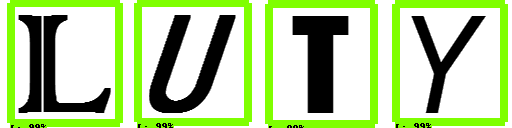


  --> palabra detectada y reconocida correctamente:  LUTY  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_19_GRB9.png : 


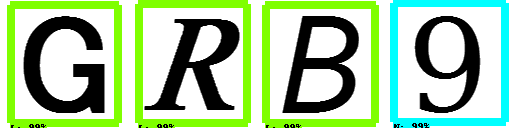


  --> palabra detectada y reconocida correctamente:  GRB9  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_22_QTLY2.png : 


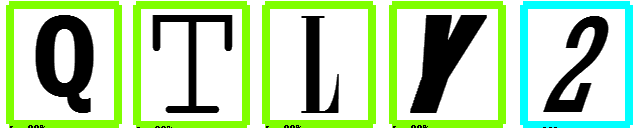


  --> palabra detectada y reconocida correctamente:  QTLY2  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_23_15EM.png : 


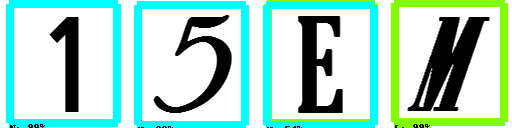


  --> palabra detectada y reconocida con error:  1CEJ !  {real:  15EM } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_24_PEK.png : 


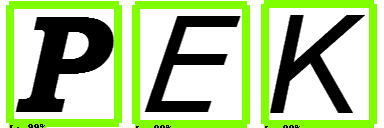


  --> palabra detectada y reconocida correctamente:  PEK  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_25_C1188.png : 


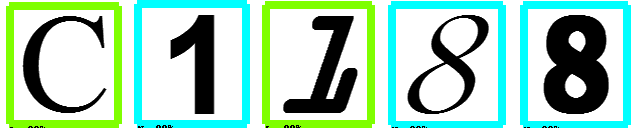


  --> palabra detectada y reconocida correctamente:  C1188  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_26_W5LR8.png : 


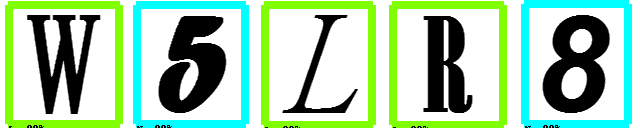


  --> palabra detectada y reconocida correctamente:  W5LR8  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_27_2006.png : 


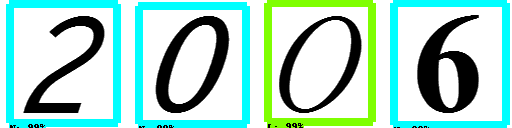


  --> palabra detectada y reconocida con error:  20O6 !  {real:  2006 } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_30_232V.png : 


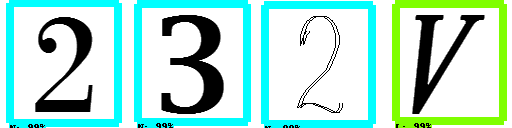


  --> palabra detectada y reconocida correctamente:  232V  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_31_W1L1.png : 


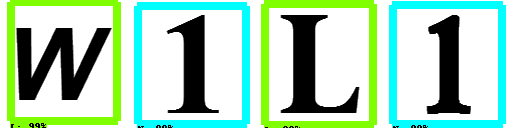


  --> palabra detectada y reconocida correctamente:  W1L1  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_35_HY9.png : 


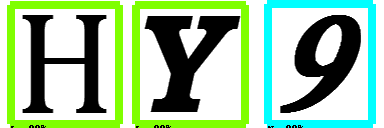


  --> palabra detectada y reconocida correctamente:  HY9  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_37_2YR.png : 


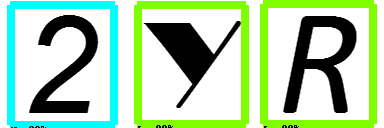


  --> palabra detectada y reconocida correctamente:  2YR  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_39_IKDKQ.png : 


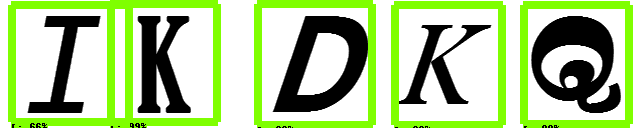


  --> palabra detectada y reconocida con error:  -KDKQ !  {real:  IKDKQ } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_41_HJQO.png : 


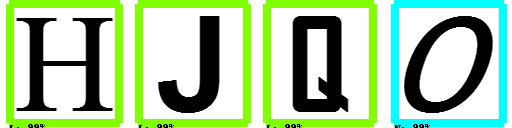


  --> palabra detectada y reconocida correctamente:  HJQO  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_50_B77QE.png : 


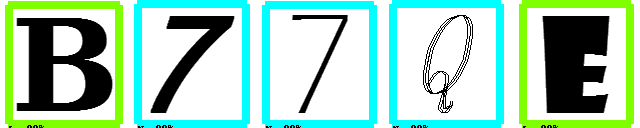


  --> palabra detectada y reconocida correctamente:  B77QE  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_58_18T.png : 


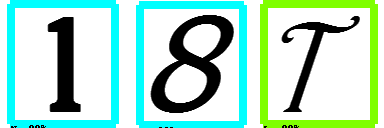


  --> palabra detectada y reconocida correctamente:  18T  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_64_1OAJ4.png : 


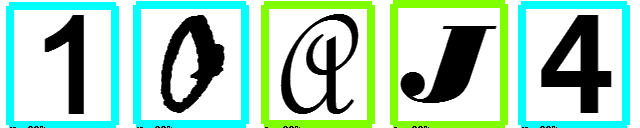


  --> palabra detectada y reconocida con error:  10QJ4 !  {real:  1OAJ4 } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_67_SSH4L.png : 


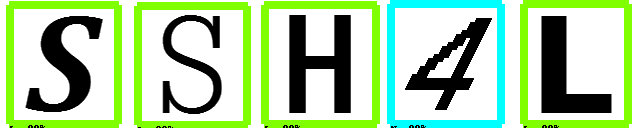


  --> palabra detectada y reconocida correctamente:  SSH4L  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_71_C3W7.png : 


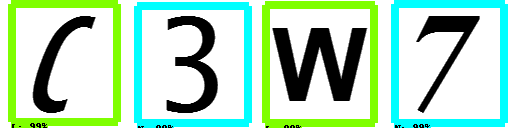


  --> palabra detectada y reconocida correctamente:  C3W7  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_81_9KSWC.png : 


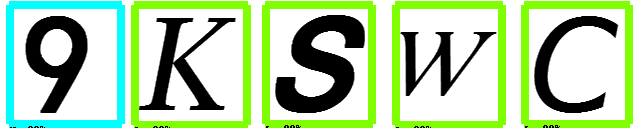


  --> palabra detectada y reconocida correctamente:  9KSWC  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_82_AFEC.png : 


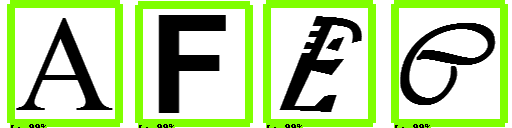


  --> palabra detectada y reconocida correctamente:  AFEC  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_86_79O.png : 


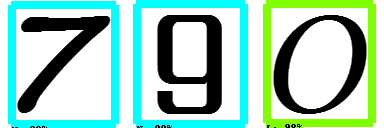


  --> palabra detectada y reconocida con error:  7QO !  {real:  79O } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_91_D39.png : 


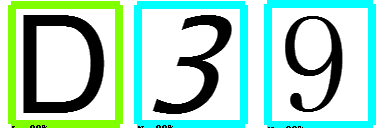


  --> palabra detectada y reconocida correctamente:  D39  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_92_UZU.png : 


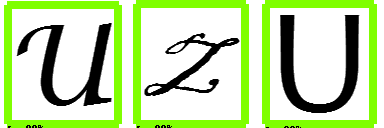


  --> palabra detectada y reconocida correctamente:  UZU  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_98_9GCH.png : 


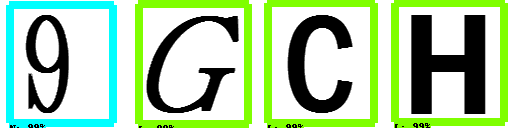


  --> palabra detectada y reconocida correctamente:  9GCH  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_108_WEKS.png : 


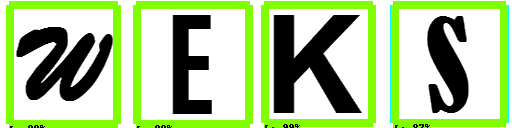


  --> palabra detectada y reconocida correctamente:  WEKS  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_109_UNH6.png : 


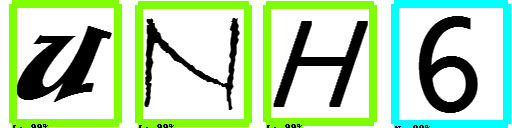


  --> palabra detectada y reconocida correctamente:  UNH6  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_119_TQ44Y.png : 


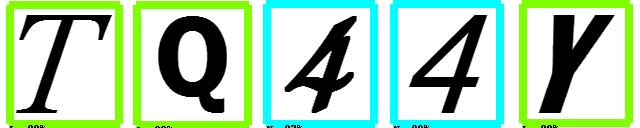


  --> palabra detectada y reconocida correctamente:  TQ44Y  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_129_7A2OX.png : 


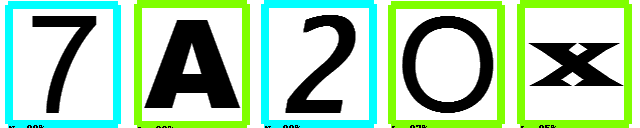


  --> palabra detectada y reconocida correctamente:  7A2OX  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_131_PXVW.png : 


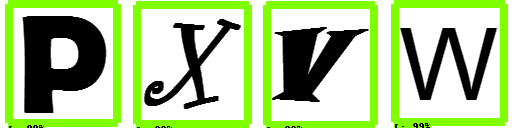


  --> palabra detectada y reconocida con error:  PXYW !  {real:  PXVW } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_133_NML.png : 


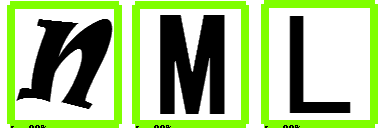


  --> palabra detectada y reconocida con error:  MML !  {real:  NML } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_134_B6L4D.png : 


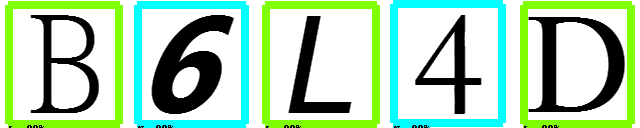


  --> palabra detectada y reconocida correctamente:  B6L4D  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_135_1IW.png : 


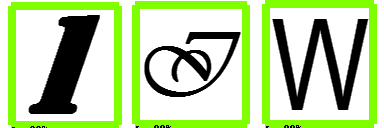


  --> palabra detectada y reconocida con error:  15W !  {real:  1IW } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_137_NXNK.png : 


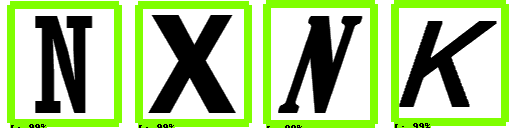


  --> palabra detectada y reconocida correctamente:  NXNK  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_140_79I.png : 


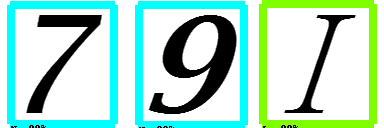


  --> palabra detectada y reconocida correctamente:  79I  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_143_XGM8.png : 


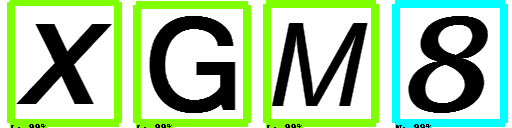


  --> palabra detectada y reconocida correctamente:  XGM8  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_151_4GI15.png : 


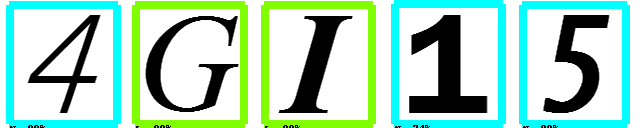


  --> palabra detectada y reconocida con error:  4GI-5 !  {real:  4GI15 } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_153_OLA1F.png : 


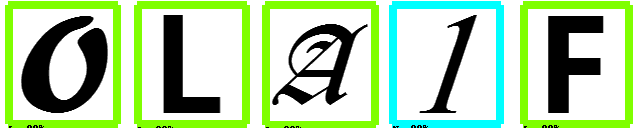


  --> palabra detectada y reconocida con error:  CL91F !  {real:  OLA1F } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_161_1RU5F.png : 


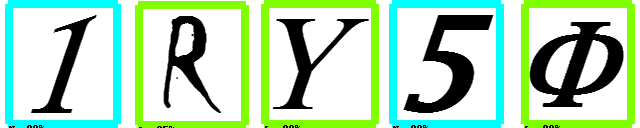


  --> palabra detectada y reconocida con error:  1RY5O !  {real:  1RU5F } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_164_3ZQ2E.png : 


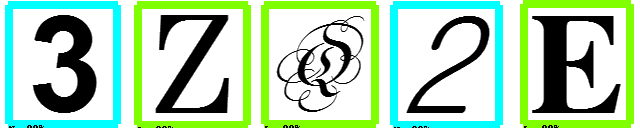


  --> palabra detectada y reconocida correctamente:  3ZQ2E  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_170_X03W6.png : 


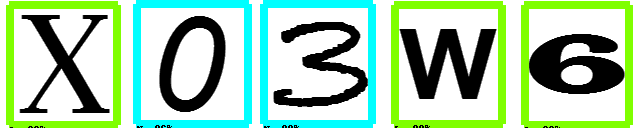


  --> palabra detectada y reconocida con error:  X03WG !  {real:  X03W6 } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_176_RLC.png : 


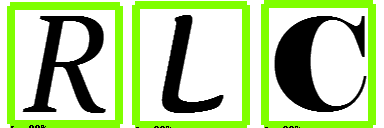


  --> palabra detectada y reconocida correctamente:  RLC  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_177_3O17.png : 


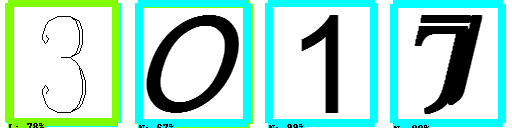


  --> palabra detectada y reconocida correctamente:  3O17  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_178_OB29.png : 


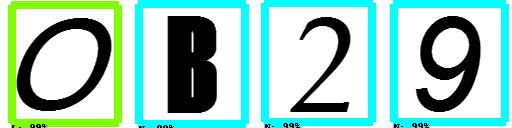


  --> palabra detectada y reconocida correctamente:  OB29  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_194_MO9Z.png : 


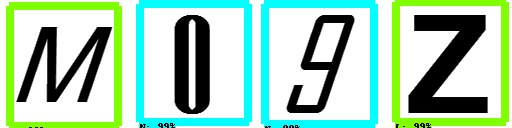


  --> palabra detectada y reconocida con error:  M09Z !  {real:  MO9Z } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_196_G8R5.png : 


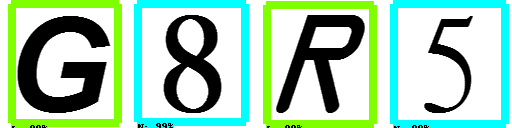


  --> palabra detectada y reconocida correctamente:  G8R5  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_199_VMV8M.png : 


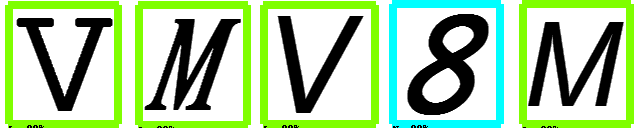


  --> palabra detectada y reconocida correctamente:  VMV8M  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_202_CTWO.png : 


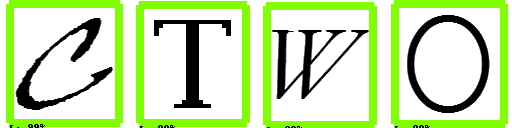


  --> palabra detectada y reconocida correctamente:  CTWO  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_212_QFY.png : 


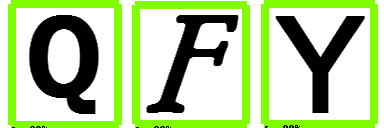


  --> palabra detectada y reconocida correctamente:  QFY  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_214_N8U9.png : 


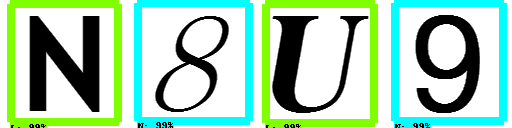


  --> palabra detectada y reconocida correctamente:  N8U9  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_215_GMBZO.png : 


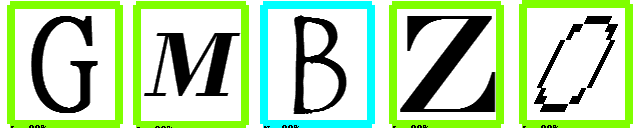


  --> palabra detectada y reconocida con error:  GMBZD !  {real:  GMBZO } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_216_I8UN.png : 


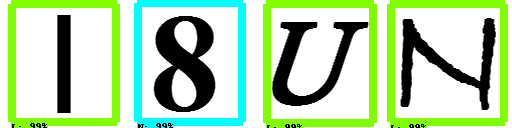


  --> palabra detectada y reconocida correctamente:  I8UN  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_220_2IJV.png : 


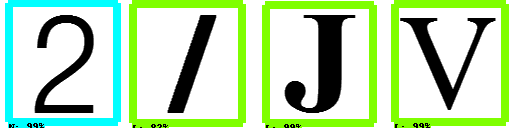


  --> palabra detectada y reconocida con error:  21JV !  {real:  2IJV } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_230_KTL.png : 


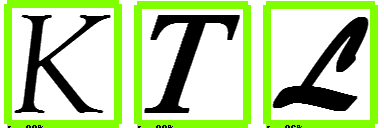


  --> palabra detectada y reconocida correctamente:  KTL  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_245_SBSV.png : 


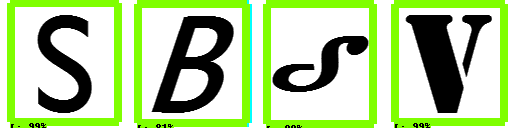


  --> palabra detectada y reconocida con error:  SBBJ !  {real:  SBSV } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_255_2RGI.png : 


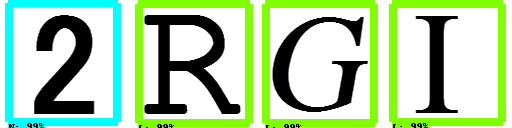


  --> palabra detectada y reconocida correctamente:  2RGI  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_257_GZ8F.png : 


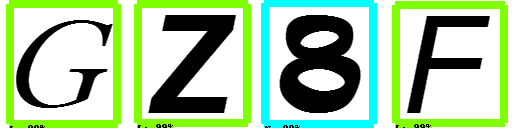


  --> palabra detectada y reconocida correctamente:  GZ8F  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_261_S5O4.png : 


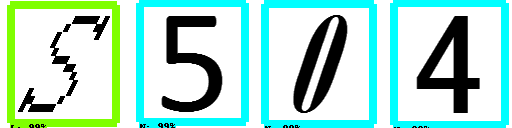


  --> palabra detectada y reconocida con error:  S504 !  {real:  S5O4 } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_262_3VPUU.png : 


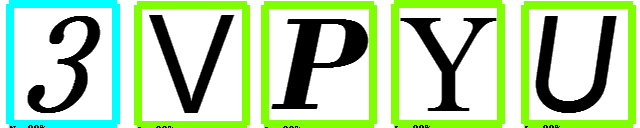


  --> palabra detectada y reconocida con error:  3VPYU !  {real:  3VPUU } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_281_B93B.png : 


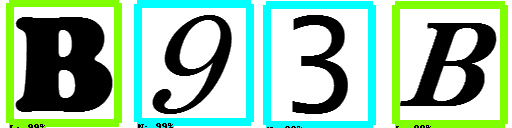


  --> palabra detectada y reconocida correctamente:  B93B  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_283_5LZCK.png : 


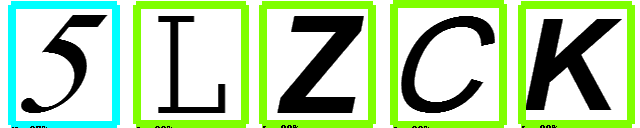


  --> palabra detectada y reconocida correctamente:  5LZCK  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_289_AHL.png : 


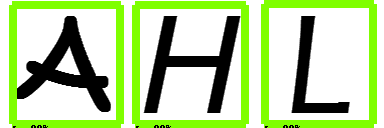


  --> palabra detectada y reconocida correctamente:  AHL  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_300_P91.png : 


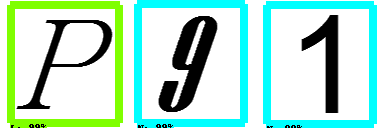


  --> palabra detectada y reconocida correctamente:  P91  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_307_X63PC.png : 


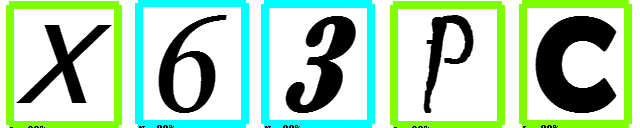


  --> palabra detectada y reconocida correctamente:  X63PC  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_311_W2YF.png : 


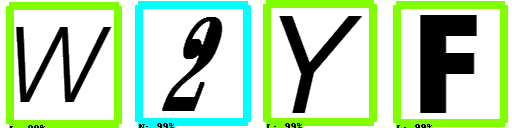


  --> palabra detectada y reconocida correctamente:  W2YF  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_313_B4OP.png : 


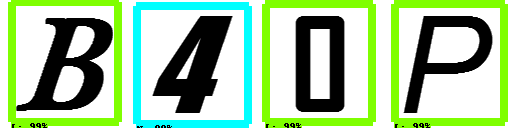


  --> palabra detectada y reconocida con error:  B4DP !  {real:  B4OP } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_315_MH0.png : 


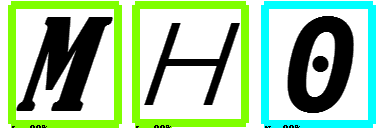


  --> palabra detectada y reconocida correctamente:  MH0  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_318_GK5TO.png : 


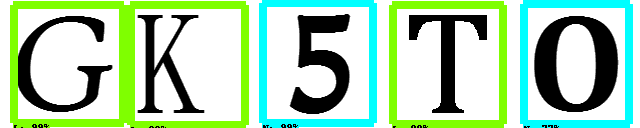


  --> palabra detectada y reconocida con error:  GK5T- !  {real:  GK5TO } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_320_ATNB.png : 


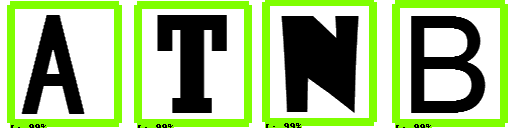


  --> palabra detectada y reconocida con error:  ATRB !  {real:  ATNB } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_329_QAWJ.png : 


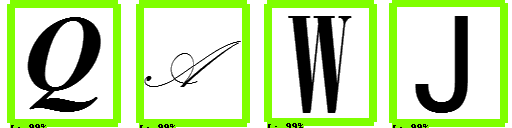


  --> palabra detectada y reconocida correctamente:  QAWJ  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_332_XGE6.png : 


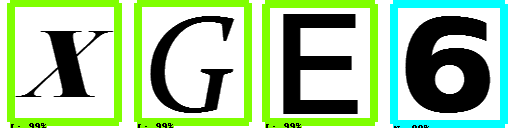


  --> palabra detectada y reconocida correctamente:  XGE6  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_340_LB29.png : 


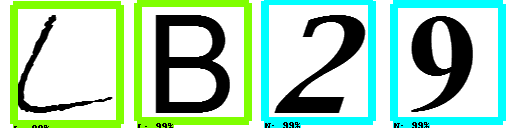


  --> palabra detectada y reconocida correctamente:  LB29  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_342_3S1.png : 


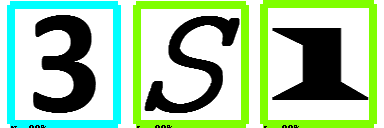


  --> palabra detectada y reconocida con error:  3SJ !  {real:  3S1 } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_352_RKO0.png : 


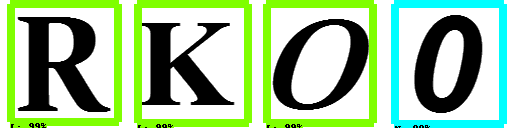


  --> palabra detectada y reconocida correctamente:  RKO0  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_353_416.png : 


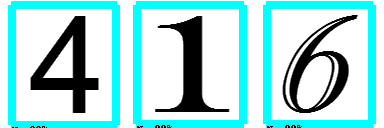


  --> palabra detectada y reconocida correctamente:  416  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_357_XMK.png : 


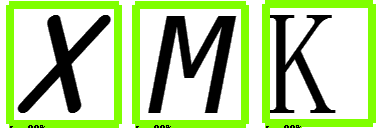


  --> palabra detectada y reconocida correctamente:  XMK  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_361_TQGD.png : 


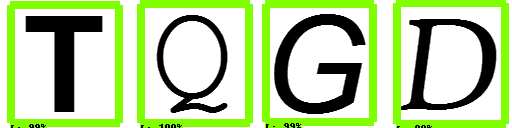


  --> palabra detectada y reconocida correctamente:  TQGD  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_368_UQM.png : 


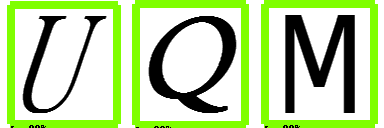


  --> palabra detectada y reconocida correctamente:  UQM  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_369_TUJX9.png : 


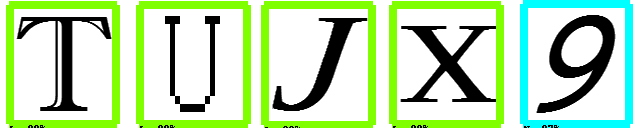


  --> palabra detectada y reconocida correctamente:  TUJX9  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_392_RTX.png : 


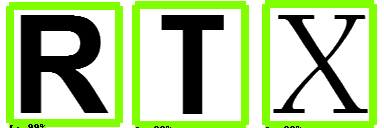


  --> palabra detectada y reconocida correctamente:  RTX  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_2_82J.png : 


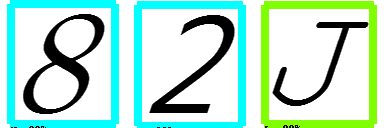


  --> palabra detectada y reconocida correctamente:  82J  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_3_93RUJ8VYIO.png : 


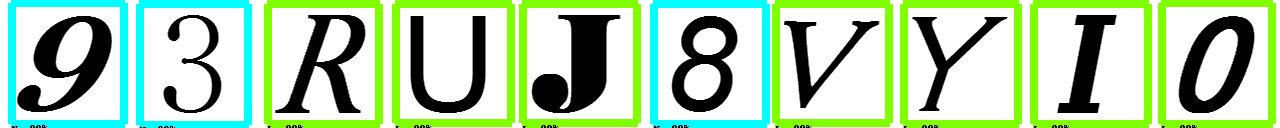


  --> palabra detectada y reconocida con error:  93RUJ8VYI0 !  {real:  93RUJ8VYIO } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_4_HH.png : 


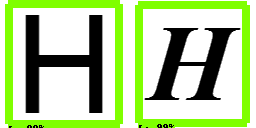


  --> palabra detectada y reconocida correctamente:  HH  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_6_77.png : 


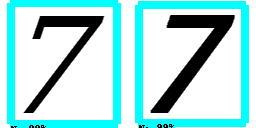


  --> palabra detectada y reconocida correctamente:  77  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_10_0YLFJRSJ3U.png : 


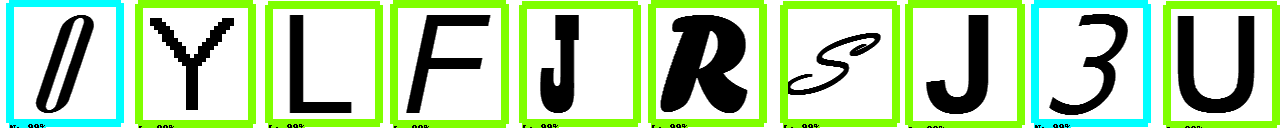


  --> palabra detectada y reconocida con error:  0YLFJR7J3U !  {real:  0YLFJRSJ3U } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_11_K7THI4H.png : 


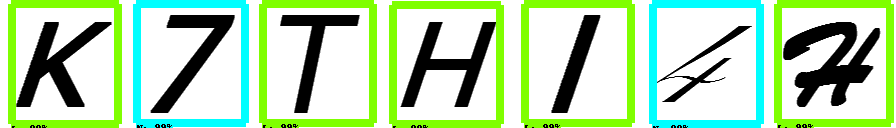


  --> palabra detectada y reconocida con error:  K7THI4J !  {real:  K7THI4H } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_16_RULX35QCRI.png : 


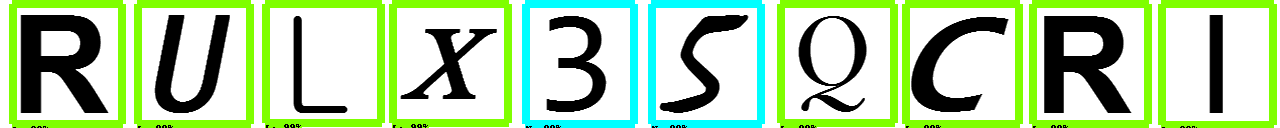


  --> palabra detectada y reconocida con error:  RULX3IQCRI !  {real:  RULX35QCRI } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_23_RMZ7C6CC.png : 


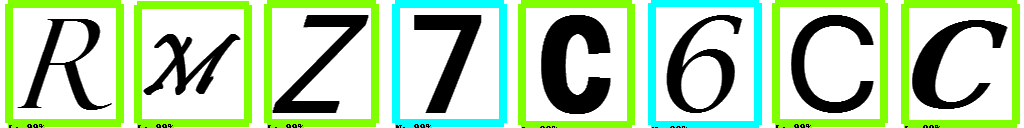


  --> palabra detectada y reconocida correctamente:  RMZ7C6CC  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_26_2I61.png : 


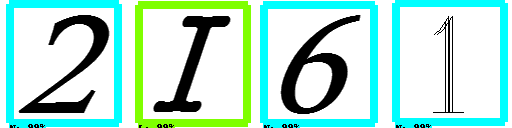


  --> palabra detectada y reconocida correctamente:  2I61  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_29_4QZ5LTUJHG.png : 


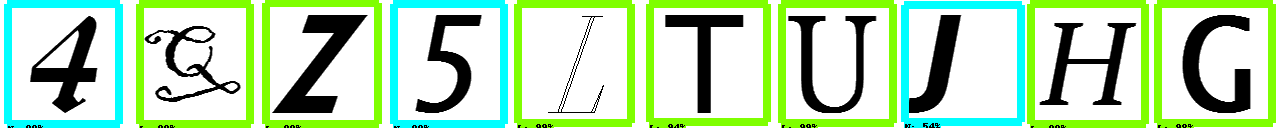


  --> palabra detectada y reconocida con error:  4QZ5LTU-HG !  {real:  4QZ5LTUJHG } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_31_K39.png : 


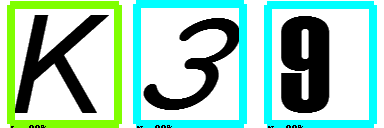


  --> palabra detectada y reconocida correctamente:  K39  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_33_VFGUZNV1M6.png : 


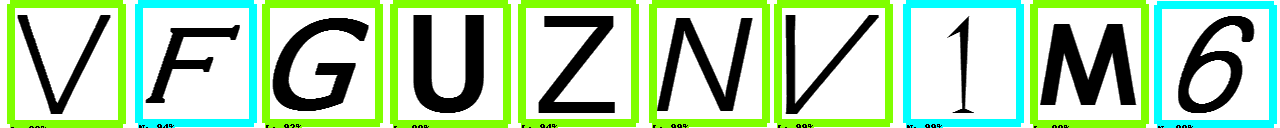


  --> palabra detectada y reconocida correctamente:  VFGUZNV1M6  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_35_MJ2AIH2ZZ.png : 


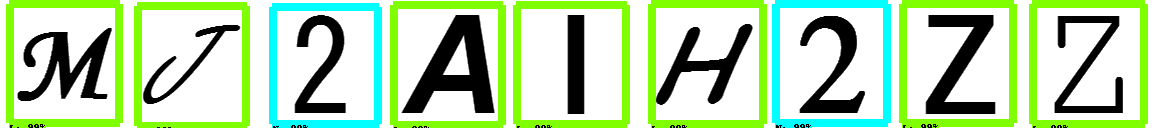


  --> palabra detectada y reconocida con error:  MJ2A1H2ZZ !  {real:  MJ2AIH2ZZ } 

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_42_UPXHQ.png : 


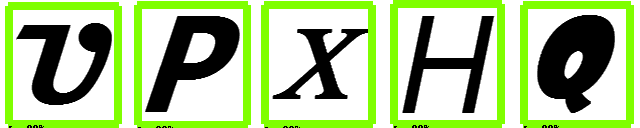


  --> palabra detectada y reconocida correctamente:  UPXHQ  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_45_JDLTUV.png : 


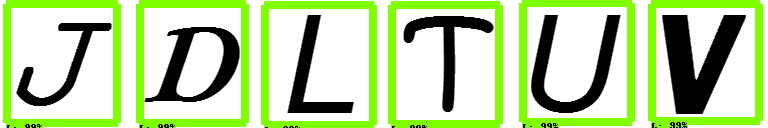


  --> palabra detectada y reconocida correctamente:  JDLTUV  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_51_BMDR1G4.png : 


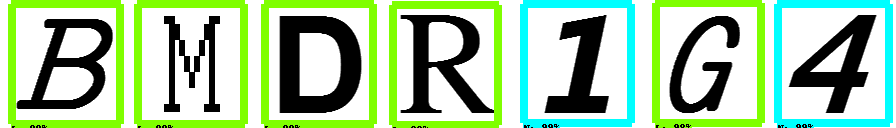


  --> palabra detectada y reconocida correctamente:  BMDR1G4  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_53_TDSR.png : 


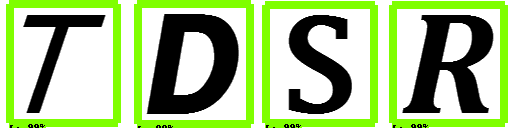


  --> palabra detectada y reconocida correctamente:  TDSR  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_56_2XJ.png : 


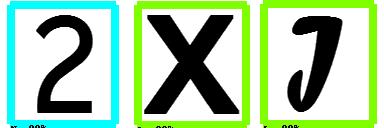


  --> palabra detectada y reconocida correctamente:  2XJ  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_57_J43MKFFG.png : 


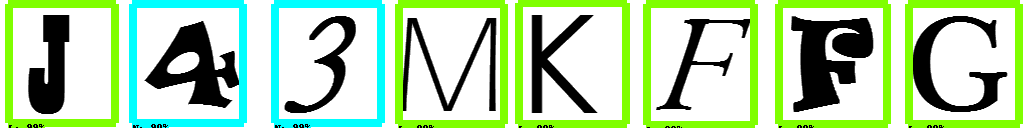


  --> palabra detectada y reconocida correctamente:  J43MKFFG  

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_62_SVKT7KHT6.png : 


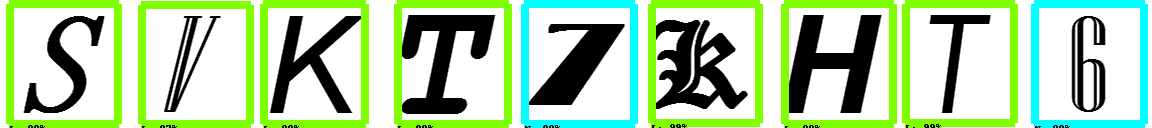


  --> palabra detectada y reconocida con error:  SVKT7RHT6 !  {real:  SVKT7KHT6 } 


************************************************************************************************* 


   * Cantidad reconocidas correctamente:  71  imágenes. 
                    --- OK sin DA:  71  imágenes. 
                    --- OK con DA:  0  imágenes. 


   * Cantidad reconocidas con error:  29  imágenes. 
                    --- Error sin DA:  29  imágenes. 
                    --- Error con DA:  0  imágenes. 


   * Efectividad Total:  71.0  % 
                    --- Efectividad sin DA:  71.0  % 


************************************************************************************************* 



In [17]:
# define minima probabilidad a usar
minProbObjDet = 80 / 100

# define si muestra detalle o no
muestraDetalle = False

# contadores auxiliares
cantImagReconOK = 0
cantImagDAReconOK = 0
cantImagReconERROR = 0
cantImagDAReconERROR = 0
vecLetrasRecon = []
vecLetrasReal = []

# procesa las imágenes 
for fn in process_FileNames:

  # define archivo a procesar y generar
  imagenProcesar = dirTest + '/' + fn

  print("\n> ", imagenProcesar, ": ")
  
  # open file to process
  imageCargada = ImPIL.open(imagenProcesar) 
  imCargada_ancho, imCargada_alto = imageCargada.size

  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(imageCargada)

  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)

  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)

  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)

  # muestra la imagen con los objetos detectados
  display( ImPIL.fromarray(image_np, 'RGB') )
  #print("    objetos detectados: ", output_dict['num_detections']) ** siempre devuelve 100

  # vector auxiliar para mostrar palabra 
  letrasDetectRecon = []

  # procesa los objetos detectados
  for detClass, detBox, detScore in zip(  output_dict['detection_classes'], output_dict['detection_boxes'], output_dict['detection_scores'] ):

      # si el objeto detectado tiene un puntaje superior o igual al mínimo
      if detScore>=minProbObjDet:

        # como las coordenadas están normalizadas las debe convertir 
        # teniendo en cuenta el tamaño de la imagen
        # además notar que vienen datas en otro orden
        # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
        # - nuevoRangoIn = (ini ancho, ini alto, fin ancho, fin alto)    
        nuevoRangoIm = (detBox[1] * imCargada_ancho, 
                        detBox[0] * imCargada_alto,
                        detBox[3] * imCargada_ancho,
                        detBox[2] * imCargada_alto) 
        centroideIm = (nuevoRangoIm[2]-nuevoRangoIm[0]/2) 

        # extrae la subimage de acuerdo al área indicada por el detector        
        imDetObj = imageCargada.crop(nuevoRangoIm )

        # ajusta el tamaño de la imagen para que sea de 128x128
        imDetObj = imDetObj.resize(model_req_image_size, ImPIL.ANTIALIAS)

        # procesa la sub-imagen con el modelo ConvNet
        result = classifier.predict( np.expand_dims(imDetObj, axis = 0) )

        # identifica mejor elemento identificado por ConvNet
        bestPos = np.argmax(result, axis=1)
        elementoReconocido = all_classes[int(bestPos)]

        letrasDetectRecon.append( [elementoReconocido, centroideIm] )

        if muestraDetalle:    
          # muestra la sub-imagen
          print("\n")
          display( imDetObj )

          # muestra resultados
          print("    - detecta ", detClass, " : ", detScore*100, "% : ", detBox, "con centroide: ", centroideIm)
          print("    +  se identifica como ",  elementoReconocido, "", result[0][bestPos] )

  # ordena las letras detectadas y reconocidas por el centroide
  oletrasDetectRecon = sorted(letrasDetectRecon, key=lambda x: x[1])
  if muestraDetalle:    
    print("\n    **  letras detectadas y reconocidas ", oletrasDetectRecon)
          
  # muestra palabra detectada y reconocida
  # (notar que en este caso no se filtran por repetidos
  #  por confiar más en el modelo detector entrenado)
  resPalabra = ""
  for letraCentr in oletrasDetectRecon:       
      resPalabra = resPalabra + letraCentr[0]

  # extrae palabra real del nombre del archivo
  imagenProcesarFN = os.path.basename(imagenProcesar)
  imPalabra = imagenProcesarFN[imagenProcesarFN.rfind('_')+1:imagenProcesarFN.rfind('.')]   

  # determina si es una imágen con Data Augmentation o no
  posImConDA = imPalabra.rfind('-') 
  if (posImConDA > 0):
      tipoDA = imPalabra[posImConDA+1:len(imPalabra)]
      imPalabra = imPalabra[0:posImConDA] 
  else:
      tipoDA = ''  

  # ajusta para que ambos queden del mismo largo
  if len(resPalabra)!=len(imPalabra):
    if len(resPalabra)<len(imPalabra):
        # si lo reconocido le falta letras, le agrega '-'
        # tratando de que sea en la posición de la letra no reconocida
        for i in range(len(imPalabra)):
          if len(resPalabra)<=i:
            resPalabra = resPalabra + '-'
          else:
                if imPalabra[i]!=resPalabra[i] and len(imPalabra)>(i+1) and (imPalabra[i+1]==resPalabra[i]):
                  resPalabra = resPalabra[0:i] + '-' + resPalabra[i:len(resPalabra)]
    else:
        # si lo reconocido es más largo, lo recorta
        resPalabra = resPalabra[0:len(imPalabra)]

    # agrega a vectores para su posterior análisis (letra por letra)
    vecLetrasRecon.extend( list(resPalabra) )
    vecLetrasReal.extend( list(imPalabra) )

  # determina si la palabra detectada está Ok o con Error
  if resPalabra==imPalabra:    
      # OK
      if (posImConDA > 0):
        print("\n  --> palabra detectada y reconocida correctamente: ", resPalabra, " (con DA:", tipoDA,") ")
        cantImagDAReconOK = cantImagDAReconOK + 1
      else:
        print("\n  --> palabra detectada y reconocida correctamente: ", resPalabra, " ")
        cantImagReconOK = cantImagReconOK + 1  
  else:   
      # con ERROR         
      if (posImConDA > 0):
          print("\n  --> palabra detectada y reconocida con error: ", resPalabra, "!  {real: ", imPalabra, " (con DA: ", tipoDA,")}")
          cantImagDAReconERROR = cantImagDAReconERROR + 1
      else:
          print("\n  --> palabra detectada y reconocida con error: ", resPalabra, "!  {real: ", imPalabra, "} ")
          cantImagReconERROR = cantImagReconERROR + 1


# muestra resultados finales
print("\n")
print("************************************************************************************************* ")
print("\n")
print("   * Cantidad reconocidas correctamente: ", cantImagReconOK+cantImagDAReconOK, " imágenes. ")
print("                    --- OK sin DA: ", cantImagReconOK, " imágenes. ")
print("                    --- OK con DA: ", cantImagDAReconOK, " imágenes. ")
print("\n")
print("   * Cantidad reconocidas con error: ", cantImagReconERROR+cantImagDAReconERROR, " imágenes. ")
print("                    --- Error sin DA: ", cantImagReconERROR, " imágenes. ")
print("                    --- Error con DA: ", cantImagDAReconERROR, " imágenes. ")
print("\n")
print("   * Efectividad Total: ", (cantImagReconOK+cantImagDAReconOK)/(cantImagReconOK+cantImagDAReconOK+cantImagReconERROR+cantImagDAReconERROR)*100, " % ")
if (cantImagReconOK+cantImagReconERROR)>0:
  print("                    --- Efectividad sin DA: ", cantImagReconOK/(cantImagReconOK+cantImagReconERROR)*100, " % ")
if (cantImagDAReconOK+cantImagDAReconERROR)>0:
  print("                    --- Efectividad con DA: ", cantImagDAReconOK/(cantImagDAReconOK+cantImagDAReconERROR)*100, " % ")
print("\n")
print("************************************************************************************************* \n")


In [18]:
# Muestra los resultados del reconocimiento, pero ahora letra por letra

from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

# vector con letras / labels
auxi = []
auxi.extend( vecLetrasReal )
auxi.extend( vecLetrasRecon )
letras = np.unique( auxi )

print("************************************************************************************************* \n")
print("> Resultados del reconocimiento letra por letra: ")
print("\n")
print("   * Exactitud General: ", accuracy_score(vecLetrasReal, vecLetrasRecon)*100, "%")

# muestra matriz de confusion
print("\n")
print("   * Matriz de Confusión (real / predecido): ")
cm = confusion_matrix(vecLetrasReal, vecLetrasRecon, labels=letras)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in letras], 
    columns=['p:{:}'.format(x) for x in letras]
  )
print(cmtx)

print("\n")
print("   * Matriz de Confusión resumida: ")
resCM = ''
for i in range(len(cm)):
  resCM = resCM + '\n      -- ' + letras[i] + ' identifica como: ' 
  for j in range(len(cm[i])):
    if cm[i][j]>0:
      resCM = resCM + letras[j] + '(' + str(cm[i][j]) + ') '
print(resCM) 

# muestra reporte de clasificación
print("\n")
print("   * Reporte de Clasificación: ")
print(classification_report(vecLetrasReal, vecLetrasRecon))

print("************************************************************************************************* \n")


************************************************************************************************* 

> Resultados del reconocimiento letra por letra: 


   * Exactitud General:  81.81818181818183 %


   * Matriz de Confusión (real / predecido): 
     p:-  p:1  p:4  p:5  p:B  p:D  p:E  ...  p:Q  p:S  p:T  p:U  p:V  p:W  p:Z
r:-    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
r:1    1    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
r:4    0    0    2    0    0    0    0  ...    0    0    0    0    0    0    0
r:5    0    0    0    3    0    0    0  ...    0    0    0    0    0    0    0
r:B    0    0    0    0    1    0    0  ...    0    0    0    0    0    0    0
r:D    0    0    0    0    0    1    0  ...    0    0    0    0    0    0    0
r:E    0    0    0    0    0    0    1  ...    0    0    0    0    0    0    0
r:G    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
r:H    0    0    0    0    0    0    0  ... 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,